In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.metrics.cluster import adjusted_rand_score

from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import time

In [2]:
def df2array(df):
    # 将数据以 ndarray 的形式读入内存
    # [[x1,x2,...,x500,y1,y2,...,y500],[],...]
    i = 0
    data = np.array([])
    while i <= len(df)-1:
        arr_x = np.array(df['x'][i:i+POINTS_NUM_PER_TR])
        arr_y = np.array(df['y'][i:i+POINTS_NUM_PER_TR])
        arr = np.append(arr_x,arr_y)
        if len(data)==0:
            data = np.array([arr])
        else:
            data = np.append(data,[arr],axis=0)
        i+=POINTS_NUM_PER_TR
    return data

In [3]:
def dist(tr1,tr2):
    length = len(tr1)
    if not(length == 1000):
        # 传入参数形式为(k,1000)
        # 计算k个簇心点更新前后的距离
        distance = 0
        for i in range(length):
            pre = tr1[i]
            now = tr2[i]
            half = int(len(pre)/2)
            x1 = pre[0:half]
            y1 = pre[half:]
            x2 = now[0:half]
            y2 = now[half:]
            deta_x = x1 - x2
            deta_y = y1 - y2
            distance = distance + np.sum((deta_x**2 + deta_y**2) ** 0.5) / len(x1)
    else:       
        half = int(length/2)
        x1 = tr1[0:half]
        y1 = tr1[half:]
        x2 = tr2[0:half]
        y2 = tr2[half:]
        deta_x = x1 - x2
        deta_y = y1 - y2
        distance = np.sum((deta_x**2 + deta_y**2) ** 0.5) / len(x1)
        # print(distance)
    return distance

In [4]:
def cluster(data,K):

    metric = distance_metric(type_metric.USER_DEFINED, func=dist)
    initial_centers = kmeans_plusplus_initializer(data, K, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()

    kmeans_instance = kmeans(data, initial_centers, metric=metric)

    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    centers = kmeans_instance.get_centers()
    
    return clusters,centers

In [5]:
# ndarray中每个元素长度要相等
def getKmeansResult(data,K):
    clusters,centers = cluster(data,K)
    labels = np.zeros(NUM_TR)
    for i in range(K):
        for j in range(NUM_TR):
            if j in clusters[i]:
                labels[j] = i
    return labels,np.array(centers)

In [6]:
def cost(data,labels,centers):
    loss = 0
    for i in range(len(data)):
        loss = loss + dist(data[i],centers[int(labels[i])])
    loss = loss / len(data)
    return loss

In [7]:
def chooseK(data,K):
    x = np.arange(3,K+1)
    y = np.zeros(len(x))
    for k in range(3,K+1):
        labels,centers = getKmeansResult(data,k)
        y[k-3] = cost(data, labels,centers)
    plt.plot(x,y)
    plt.grid(True)
    plt.show()

In [8]:
def stableClustering(data,k):
    labels,centers = getKmeansResult(data,k)
    min_cost = cost(data,labels,centers)
    for i in range(30): # 取10次聚类中损失函数最小的
        labels_,centers_ = getKmeansResult(data,k)
        cost_ = cost(data,labels_,centers_)
        if cost_ < min_cost:
            labels = labels_
            centers = centers_
            min_cost = cost_
    print('min_cost:'+str(min_cost))
    return labels,centers

In [7]:
POINTS_NUM_PER_TR = 500

df = pd.read_csv('./data/all.csv')

NUM_TR = int(len(df)/POINTS_NUM_PER_TR)

In [8]:
NUM_TR

549

In [9]:
data = df2array(df)

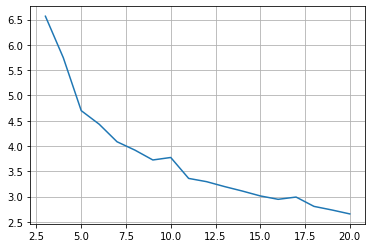

In [99]:
chooseK(data,20)

In [138]:
K = 6

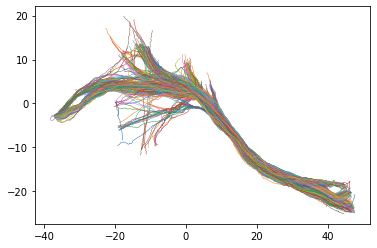

In [47]:
for i in range(len(data)):
    x = data[i][:500]
    y = data[i][500:]
    plt.plot(x,y,linewidth = 0.5)
plt.show()

### baseline是标准答案

In [145]:
labels,centers = stableClustering(data,K)

min_cost:4.325291074096967


In [146]:
baseline = labels.tolist()

In [147]:
len(baseline)

549

In [148]:
import json
with open('./baselineK6.txt','w') as f:#dict转txt
    json.dump(json.dumps(baseline),f)
f.close()

### 检测同样的数据集两次聚类结果的RI

In [19]:
from itertools import combinations

In [20]:
def RI(a,b):
    ss = 0
    dd = 0
    sum = 0
    for com in combinations(range(len(a)),2):
        sum = sum + 1
        if (a[com[0]] == a[com[1]]) and (b[com[0]] == b[com[1]]):
            ss = ss + 1
        if (a[com[0]] != a[com[1]]) and (b[com[0]] != b[com[1]]):
            dd = dd + 1
    return (ss + dd) / sum

In [151]:
def stableClustering(data,k):
    labels,centers = getKmeansResult(data,k)
    min_cost = cost(data,labels,centers)
    for i in range(50): # 取30次聚类中损失函数最小的
        labels_,centers_ = getKmeansResult(data,k)
        cost_ = cost(data,labels_,centers_)
        if cost_ < min_cost:
            labels = labels_
            centers = centers_
            min_cost = cost_
    print(min_cost)
    return labels,centers

In [149]:
ri = 0
ari = 0
N = 5
for i in range(N):
    l1,c = stableClustering(data,K)
    #l2,c = stableClustering(data,K)
    ri = ri + RI(l1,baseline)
    ari = ari + adjusted_rand_score(l1,baseline)
    print(RI(l1,baseline),adjusted_rand_score(l1,baseline))
print(ri/N,ari/N)

min_cost:4.325291074096967
1.0 1.0
min_cost:4.325291074096967
1.0 1.0
min_cost:4.325291074096967
1.0 1.0
min_cost:4.325291074096967
1.0 1.0
min_cost:4.325291074096967
1.0 1.0
1.0 1.0


### 保证针对同一数据集RI指数要高于0.98